### Project and data are based on a free, online course of machine learning https://www.coursera.org/learn/machine-learning. I wholeheartedly recommend this! 

## I will show how do it in Python:
    + visualize overfitting(high variance) and underfitting(high bias), 
    + choose best degree of polynomial,
    + use train, cross validation and test data set.


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.optimize import minimize
import scipy.io
import warnings
import sys


# ignore warnings
warnings.filterwarnings('ignore')

# write packages and python version to file
'''
! python -m pip list > packages_versions.txt
# a append to file
with open('packages_versions.txt', 'a') as f:
    f.write('Python version ' + str(sys.version))
'''

In [2]:
# load all needed data
data = scipy.io.loadmat('ex5data1.mat')
X = data['X']
Y = data['y']
X_val = data['Xval']
Y_val = data['yval']
X_test = data['Xtest']
Y_test = data['ytest']

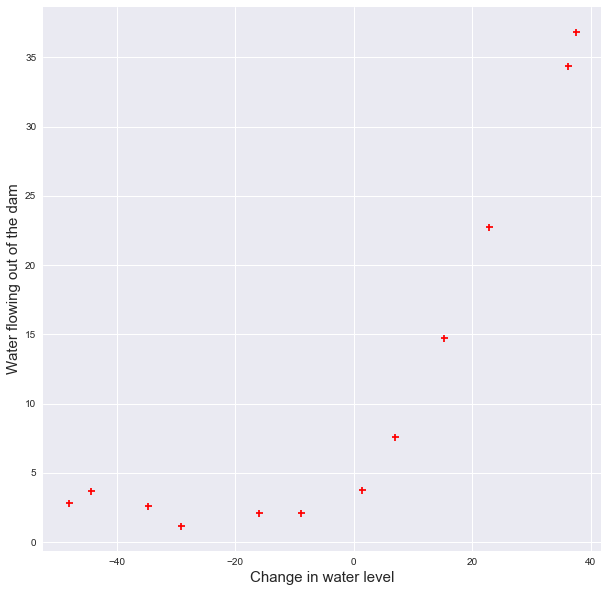

In [3]:
# plot data
fig = plt.figure(figsize=(10,10)) 
ax = fig.gca()
ax.scatter(X,Y, marker = '+', color = 'r')
ax.set_xlabel('Change in water level', size = 15)
ax.set_ylabel('Water flowing out of the dam', size = 15)

In [4]:
def con_ones(X):
    m = len(X)
    ones = np.ones((m,1))
    return np.concatenate((ones, X), 1)

def J_grad_reg(theta, X,Y, lambda_ = 0):
    theta = np.reshape(theta, (theta.shape[0],1))
    m = X.shape[0]
    J = (np.sum((X @ theta - Y)**2) + np.sum(lambda_* theta[1:] ** 2))/(2*m)
    
    noreg_grad = X.T@(X@theta - Y)
    reg_grad = lambda_*theta
    reg_grad[0] = 0
    grad = ((noreg_grad + reg_grad)/m).flatten()
    
    return J, grad

def train_linear_regression(X,Y, lambda_):
    '''
    Returns theta that minimizes cost function.
    '''
    initial_theta = np.zeros((X.shape[1]))
    res = minimize(J_grad_reg, initial_theta, jac = True, args = (X, Y, lambda_), method = 'CG',
                  options = {'maxiter' : 200})
    theta_min = res.x
    
    return theta_min[np.newaxis].T

def learning_curve(X, Y, X_val, Y_val, lambda_):
    '''
    Computes train and validation error for more and more examples.
    '''
    m = len(X)
    error_train = np.zeros((m, 1))
    error_val   = np.zeros((m, 1))
    for k in range(1, m + 1):
        X_train = X[:k]
        Y_train = Y[:k]
        theta = train_linear_regression(X_train, Y_train, lambda_)
        error_train[k-1] = J_grad_reg(theta, X_train, Y_train, lambda_ = 0)[0]
        error_val[k-1] = J_grad_reg(theta, X_val, Y_val, lambda_ = 0)[0]
    return error_train, error_val 
        
def poly_feature(X, p):
    '''
    Extends X to [X, X**2, ..., X**p]
    '''
    return X ** np.arange(1, p+1)
  
def normalize(X, *args):
    '''
    Normalizes data using mu, sigma from X if are not given.
    '''
    if not len(args):
        mu = np.mean(X, axis = 0)
        sigma = np.std(X, axis = 0, ddof = 1)
    else:
        mu = args[0]
        sigma = args[1]
    return (X - mu)/sigma, mu, sigma

def plot_fit(min_x, max_x, mu, sigma, theta, p):
    '''
    Plots fitted curve.
    '''
    X = np.linspace(min_x - 20, max_x + 20, 1000)[np.newaxis].T
    X_poly = poly_feature(X, p)
    X_poly = (X_poly - mu)/sigma
    X_poly = con_ones(X_poly)
    plt.plot(X, X_poly @ theta, marker = '_')
    
def validation_curve(X_train, Y_train , X_val, Y_val, lambdas):
    '''
    Computes train and validation error for different regulazation parameter (lambda)
    '''
    train_err = []
    val_err = []
    for lambda_ in lambdas:
        theta_min = train_linear_regression(X_train,Y_train, lambda_)
        train_err.append(J_grad_reg(theta_min, X_train, Y_train, 0)[0])
        val_err.append(J_grad_reg(theta_min, X_val, Y_val, 0)[0])
    return train_err, val_err

In [5]:
# Lets do test for cost and gradient function
X_ones = con_ones(X)
theta = np.array([[1], [1]])
lambda_ = 1
J_check, grad_check = J_grad_reg(theta, X_ones,Y,lambda_)
assert np.allclose(J_check, 303.993192)
assert np.allclose(grad_check, np.array([-15.303016, 598.250744]))

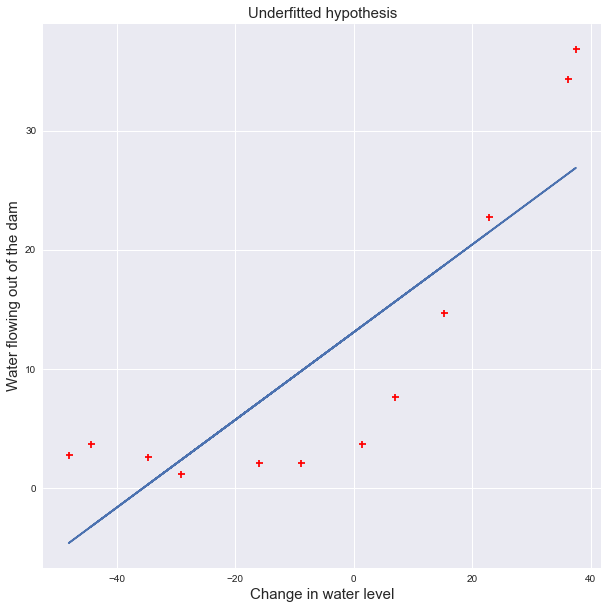

In [6]:
lambda_ = 0
theta = train_linear_regression(X_ones,Y, lambda_)
ax.plot(X, X_ones @ theta)
ax.set_title('Underfitted hypothesis', size = 15)
fig

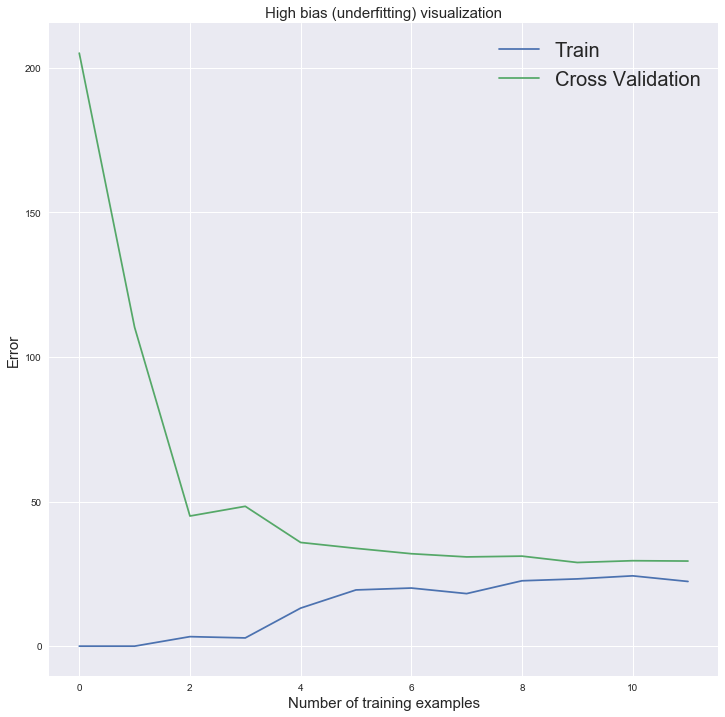

In [7]:
lambda_ = 0
X_val_ones = con_ones(X_val)
# find train and validation error for number of example = 1, ..., all
error_train, error_val = learning_curve(X_ones, Y, X_val_ones, Y_val, lambda_)

plt.figure(figsize=(12,12))
plt.plot(error_train, label = 'Train')
plt.plot(error_val, label = 'Cross Validation')
plt.legend(prop={'size': 20})
plt.xlabel('Number of training examples', size = 15)
plt.ylabel('Error', size = 15)
plt.title('High bias (underfitting) visualization', size = 15);

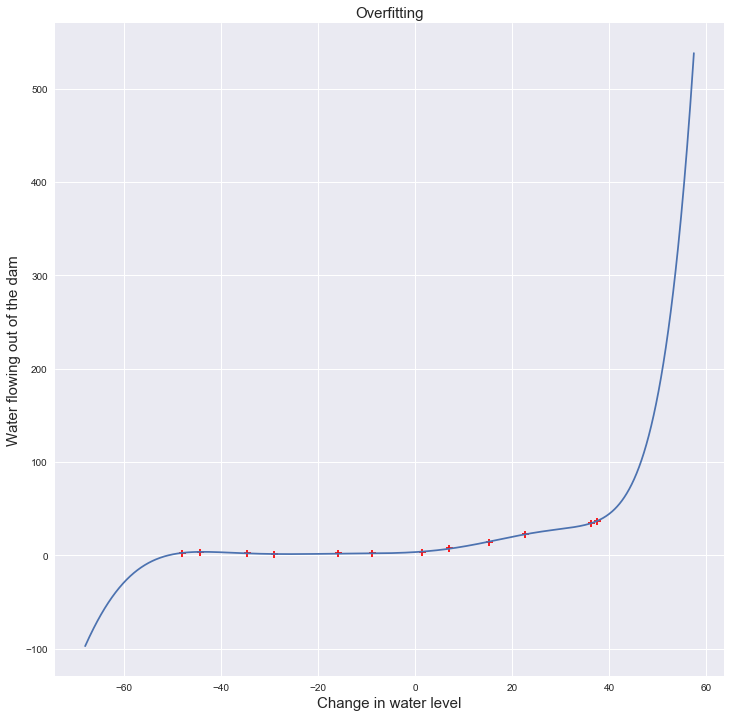

In [8]:
lambda_ = 0
# degree of polynomial is high and train set small, so overfitting is very likely
p = 8

X_poly_train = poly_feature(X, p)
X_poly_train, mu, sigma = normalize(X_poly_train)
X_poly_train = con_ones(X_poly_train)


X_poly_val = poly_feature(X_val, p)
X_poly_val = normalize(X_poly_val, mu, sigma)[0]
X_poly_val = con_ones(X_poly_val)

X_poly_test = poly_feature(X_test, p)
X_poly_test = normalize(X_poly_test, mu, sigma)[0]
X_poly_test = con_ones(X_poly_test)

plt.figure(figsize=(12,12))
theta_min = train_linear_regression(X_poly_train, Y, lambda_)
plt.scatter(X,Y, marker = '+', color = 'r')
plot_fit(np.min(X), np.max(X), mu, sigma, theta_min, p)
plt.title('Overfitting', size = 15)
plt.xlabel('Change in water level', size = 15)
plt.ylabel('Water flowing out of the dam', size = 15);





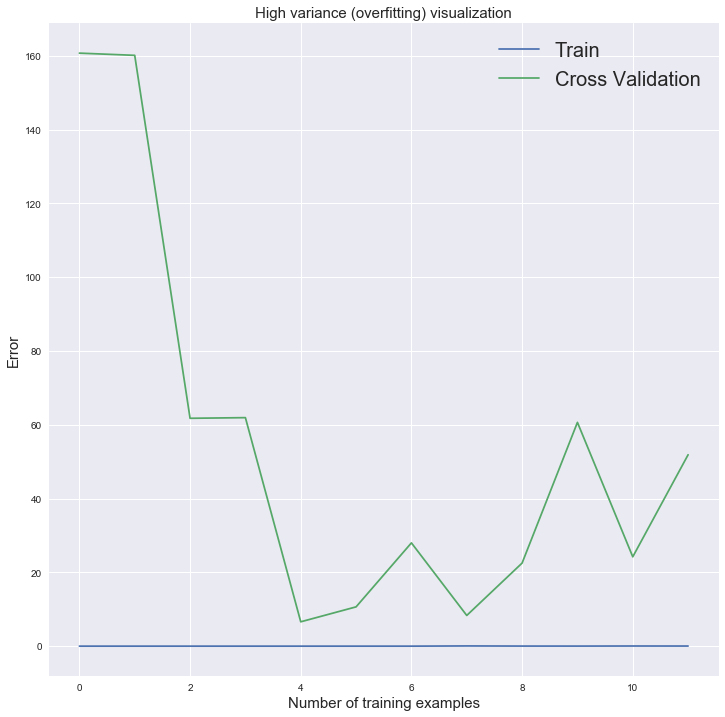

In [9]:
# find train and validation error for number of example = 1, ..., all
error_train, error_val = learning_curve(X_poly_train, Y, X_poly_val, Y_val, lambda_)
plt.figure(figsize=(12,12))
plt.plot(error_train, label = 'Train')
plt.plot(error_val, label = 'Cross Validation')
plt.legend(prop={'size': 20})
plt.xlabel('Number of training examples', size = 15)
plt.ylabel('Error', size = 15)
plt.title('High variance (overfitting) visualization', size = 15);

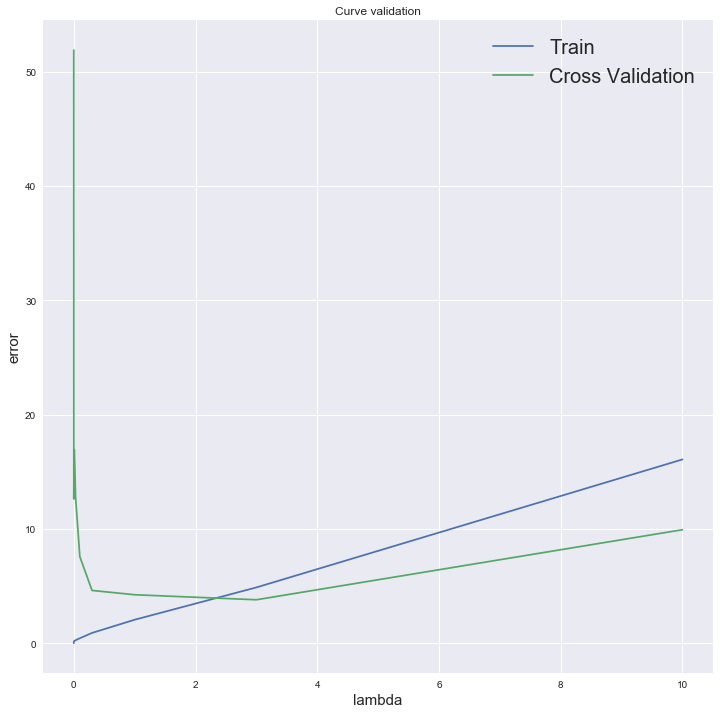

In [10]:
lambdas = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_err, val_err = validation_curve(X_poly_train, Y , X_poly_val, Y_val, lambdas)
plt.figure(figsize = (12,12))
plt.plot(lambdas, train_err, label = 'Train')
plt.plot(lambdas, val_err, label = 'Cross Validation')
plt.legend(prop={'size': 20})
plt.xlabel('lambda', size = 15)
plt.ylabel('error', size = 15)
plt.title('Curve validation');

In [11]:
# Train model with lambda_ = 3. It corespondes to the smallest value of cross validation error.
theta_min2 = train_linear_regression(X_poly_val,Y_val, 3)
print('Generalized error on unknown test set = {:.2f}'.format(J_grad_reg(theta_min2, X_poly_test,Y_test)[0]))

Generalized error on unknown test set = 6.33
